# Binary Classification Neural Network from Scratch
## Introduction

This notebook builds a deep neural network for binary images classification tasks. 

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations.

## Table of Contents

- [1 - Packages](#1)
- [2 - Outline](#2)
- [3 - Initialisation](#3)
    - [3.1 - 2-layer Neural Network](#3-1)
        - [01 - initialise_parameters](#ex-1)
    - [3.2 - L-layer Neural Network](#3-2)
        - [02 - initialise_parameters_deep](#ex-2)
- [4 - Forward Propagation Module](#4)
    - [4.1 - Linear Forward](#4-1)
        - [03 - linear_forward](#ex-3)
    - [4.2 - Linear-Activation Forward](#4-2)
        - [04 - linear_activation_forward](#ex-4)
    - [4.3 - L-Layer Model](#4-3)
        - [05 - L_model_forward](#ex-5)
- [5 - Cost Function](#5)
    - [06 - compute_cost](#ex-6)
- [6 - Backward Propagation Module](#6)
    - [6.1 - Linear Backward](#6-1)
        - [07 - linear_backward](#ex-7)
    - [6.2 - Linear-Activation Backward](#6-2)
        - [08 - linear_activation_backward](#ex-8)
    - [6.3 - L-Model Backward](#6-3)
        - [09 - L_model_backward](#ex-9)
    - [6.4 - Update Parameters](#6-4)
        - [010 - update_parameters](#ex-10)
- [7 - Load and Process the Dataset](#7)
- [8 - Model Architecture](#8)
    - [8.1 - 2-layer Neural Network](#8-1)
    - [8.2 - L-layer Deep Neural Network](#8-2)
    - [8.3 - General Methodology](#8-3)
- [9 - Two-layer Neural Network](#9)
    - [011 - two_layer_model](#ex-11)
    - [9.1 - Train the model](#9-1)
- [10 - L-layer Neural Network](#10)
    - [012 - L_layer_model](#ex-12)
    - [10.1 - Train the model](#10-1)
- [11 - Test with your own images](#11)

<a name='1'></a>
## 1 - Packages

First, import all the packages needed in this notebook. 

- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test the model with pictures not in the datasets.
- utils.py provides some necessary functions for this notebook.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# Here are some helper functions
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


<a name='2'></a>
## 2 - Outline

- Initialise the parameters for a two-layer network and for an $L$-layer neural network
- Implement the forward propagation module (shown in purple in the figure below)
     - Complete the LINEAR part of a layer's forward propagation (resulting in $Z^{[l]}$)
     - Complete the ACTIVATION part of a layer's forward propagation (relu/sigmoid)
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$), which gives a new L_model_forward function
- Compute the loss
- Implement the backward propagation module (denoted in red in the figure below)
    - Complete the LINEAR part of a layer's backward propagation
    - Find the gradient of the ACTIVATION function of a layer's backward propagation (relu_backward/sigmoid_backward) 
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally, update the parameters

<img src="images/final outline.png" style="width:800px;height:500px;">
<caption><center><b>Figure 1</b></center></caption><br>

<!-- <img src="/part3/images/final outline.png" style="width:800px;height:500px;"> -->
<!-- <caption><center><b>Figure 1</b></center></caption><br> -->

**Note**:

For every forward function, there is a corresponding backward function. This is why at every step of your forward module we will be storing some values in a cache. These cached values are useful for computing gradients in the backpropagation module.

<a name='3'></a>
## 3 - Initialisation

The first function will be used to initialise parameters for a two layer model. The second one generalises this initialisation process to $L$ layers.

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

<a name='ex-1'></a>
### 01 - initialize_parameters

In [3]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

<a name='3-2'></a>
### 3.2 - L-layer Neural Network

Recall that $n^{[l]}$ is the number of units in layer $l$. For example, if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:
|     | **Shape of W**          | **Shape of b** | **Activation**                           | **Shape of Activation** |
| --- | ----------------------- | --------------- | ---------------------------------------- | ------------------------ |
| **Layer 1** | $(n^{[1]},12288)$ | $(n^{[1]},1)$  | $Z^{[1]} = W^{[1]}  X + b^{[1]}$       | $(n^{[1]},209)$          |
| **Layer 2** | $(n^{[2]}, n^{[1]})$  | $(n^{[2]},1)$ | $Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ | $(n^{[2]}, 209)$         |
| $\vdots$    | $\vdots$              | $\vdots$       | $\vdots$                                | $\vdots$                 |
| **Layer L-1** | $(n^{[L-1]}, n^{[L-2]})$ | $(n^{[L-1]}, 1)$ | $Z^{[L-1]} = W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ | $(n^{[L-1]}, 209)$ |
| **Layer L** | $(n^{[L]}, n^{[L-1]})$   | $(n^{[L]}, 1)$ | $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$ | $(n^{[L]}, 209)$ |

Remember that when you compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22} 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22} 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}$$

<a name='ex-2'></a>
### 02 - initialise_parameters_deep

In [4]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """

    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

<a name='4'></a>
## 4 - Forward Propagation Module

<a name='4-1'></a>
### 4.1 - Linear Forward 

The structure for the forward module is

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorised over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

where $A^{[0]} = X$. 

<a name='ex-3'></a>
### 03 - linear_forward 

In [5]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

<a name='4-2'></a>
### 4.2 - Linear-Activation Forward

The activation functions we will use are *Sigmoid* and *ReLU*, which are contained in the file utils.py.

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: $RELU(Z) = max(0, Z)$. 
``` python
A, activation_cache = relu(Z)
```
$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu().

### 04 - linear_activation_forward

In [6]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

<a name='4-3'></a>
### 4.3 - L-Layer Model 

We will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

<a name='ex-5'></a>
### 05 -  L_model_forward

In [7]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2             # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], 'relu')
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)],'sigmoid')
    caches.append(cache)
 
    return AL, caches

<a name='5'></a>
## 5 - Cost Function

Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$

<a name='ex-6'></a>
### 06 - compute_cost

In [8]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    cost = -1/m * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    cost = np.squeeze(cost)      # To make sure the cost's shape is what we expect (e.g. this turns [[17]] into 17).

    
    return cost

<a name='6'></a>
## 6 - Backward Propagation Module

Now, similarly to forward propagation, we will build the backward propagation in three steps:
1. LINEAR backward
2. LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

<img src="images/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center><font color='purple'><b>Figure 3</b>: Forward and Backward propagation for LINEAR->RELU->LINEAR->SIGMOID <br> <i>The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.</font></center></caption>


<a name='6-1'></a>
### 6.1 - Linear Backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose we have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{J} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<img src="images/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center><font color='purple'><b>Figure 4</b></font></center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{J} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

<a name='ex-7'></a>
### 07 - linear_backward 

In [9]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m * dZ @ A_prev.T
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = W.T @ dZ
    
    
    return dA_prev, dW, db

<a name='6-2'></a>
### 6.2 - Linear-Activation Backward

We use two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`** in the file utils.py. 


- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit.

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit.

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}).$$  

<a name='ex-8'></a>
### 08 -  linear_activation_backward

In [10]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    
    return dA_prev, dW, db

<a name='6-3'></a>
### 6.3 - L-Model Backward 

Recall that when you implemented the `L_model_forward` function, at each iteration, we stored a cache which contains (X, W, b, and z). In the back propagation module, we will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, we will iterate through all the hidden layers backward, starting from layer $L$. On each step, we will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<img src="images/mn_backward.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 5</b>: Backward pass</font></center></caption>

**Initialising backpropagation**:

To backpropagate through this network, we know that the output is: 
$A^{[L]} = \sigma(Z^{[L]})$. We compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
by:
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

We can then use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, we now feed in `dAL` into the LINEAR->SIGMOID backward function we implemented (which will use the cached values stored by the L_model_forward function). 

After that, we will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function and  store each dA, dW, and db in the grads dictionary. 

<a name='ex-9'></a>
### 09 -  L_model_backward

In [11]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL    
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

<a name='6-4'></a>
### 6.4 - Update Parameters

We update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

where $\alpha$ is the learning rate. 

<a name='ex-10'></a>
### 010 - update_parameters

In [12]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

<a name='7'></a>
## 7 - Load and Process the Dataset

We have a dataset ("data.h5") containing:

- a training set of `m_train` images labelled as cat (1) or non-cat (0)
- a test set of `m_test` images labelled as cat and non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

In [13]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


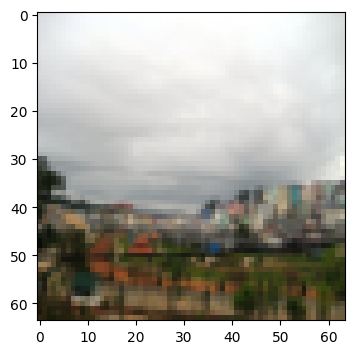

In [14]:
# Example of a picture
index = 17
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [15]:
# Explore the dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Next, we reshape and standardise the images before feeding them to the network. 

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 6</b>: Image to vector conversion.</font></center></caption>

**Note**:
$12,288$ equals $64 \times 64 \times 3$, which is the size of one reshaped image vector.

In [16]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


<a name='8'></a>
## 8 - Model Architecture

<a name='8-1'></a>
### 8.1 - 2-layer Neural Network

We will build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, we will compare the performance of these models, and try out some different values for $L$. 

Let's look at the two architectures:

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 7</b>: 2-layer neural network. <br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.</font></center></caption>

<u><b>Detailed Architecture of Figure 7</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

<a name='8-2'></a>
### 8.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 8</b>: L-layer neural network. <br> The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID</font></center></caption>

<u><b>Detailed Architecture of Figure 8</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

<a name='8-3'></a>
### 8.3 - General Methodology

1. Initialise parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

In [17]:
# Here are some helper functions

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


<a name='9'></a>
## 9 - Two-layer Neural Network

<a name='ex-11'></a>
### 011 - two_layer_model 

In [18]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [19]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """

    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initialising backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

<a name='9-1'></a>
### 9.1 - Train the model 

Cost after iteration 0: 0.6909089739307406
Cost after iteration 100: 0.6428467622939883
Cost after iteration 200: 0.6233198151635093
Cost after iteration 300: 0.5865861711301438
Cost after iteration 400: 0.541869858808677
Cost after iteration 500: 0.4924866236754481
Cost after iteration 600: 0.433379302847892
Cost after iteration 700: 0.38879930723059064
Cost after iteration 800: 0.3786701565545842
Cost after iteration 900: 0.3460553291657384
Cost after iteration 1000: 0.32208744698362113
Cost after iteration 1100: 0.28169971026737994
Cost after iteration 1200: 0.18912967080622395
Cost after iteration 1300: 0.15908894551931724
Cost after iteration 1400: 0.14141035296695234
Cost after iteration 1500: 0.10722603196882437
Cost after iteration 1600: 0.0900177728269557
Cost after iteration 1700: 0.07837362058694812
Cost after iteration 1800: 0.06567317649471192
Cost after iteration 1900: 0.05716857322409934
Cost after iteration 2000: 0.05041393217938125
Cost after iteration 2100: 0.04448521

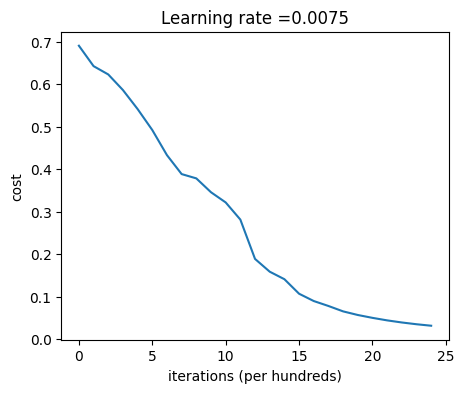

In [20]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [21]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [22]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


<a name='10'></a>
## 10 - L-layer Neural Network

<a name='ex-12'></a>
### 012 - L_layer_model 

In [23]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1]

In [24]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                         # keep track of cost
    

    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

<a name='10-1'></a>
### 10.1 - Train the model 

In [25]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.6931474028296922
Cost after iteration 100: 0.6780091341477542
Cost after iteration 200: 0.6675974006508378
Cost after iteration 300: 0.6604193469701339
Cost after iteration 400: 0.6554554050375472
Cost after iteration 500: 0.6520112971275809
Cost after iteration 600: 0.6496139504215879
Cost after iteration 700: 0.6479401688280813
Cost after iteration 800: 0.6467683504575845
Cost after iteration 900: 0.6459459464195001
Cost after iteration 1000: 0.6453675241385547
Cost after iteration 1100: 0.6449599385315885
Cost after iteration 1200: 0.6446722671482963
Cost after iteration 1300: 0.6444689471149623
Cost after iteration 1400: 0.6443250729668354
Cost after iteration 1500: 0.6442231601295626
Cost after iteration 1600: 0.6441509075860217
Cost after iteration 1700: 0.6440996451590179
Cost after iteration 1800: 0.6440632520941265
Cost after iteration 1900: 0.6440374015193283
Cost after iteration 2000: 0.6440190311176397
Cost after iteration 2100: 0.644005971391421
C

In [26]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [27]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001


<a name='11'></a>
##  11 - Test with your own images

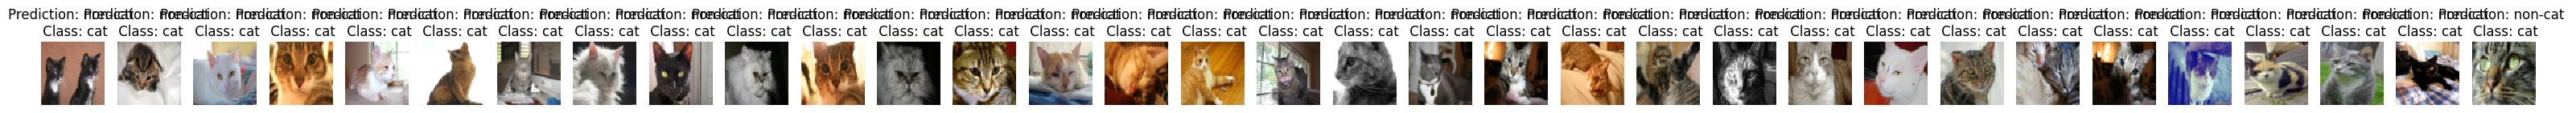

In [28]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

From this point, if you so choose, you can use your own image to test  the output of your model. To do that follow these steps:

1. Add your image to this Jupyter Notebook's directory, in the "images" folder
2. Change your image's name in the following code
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


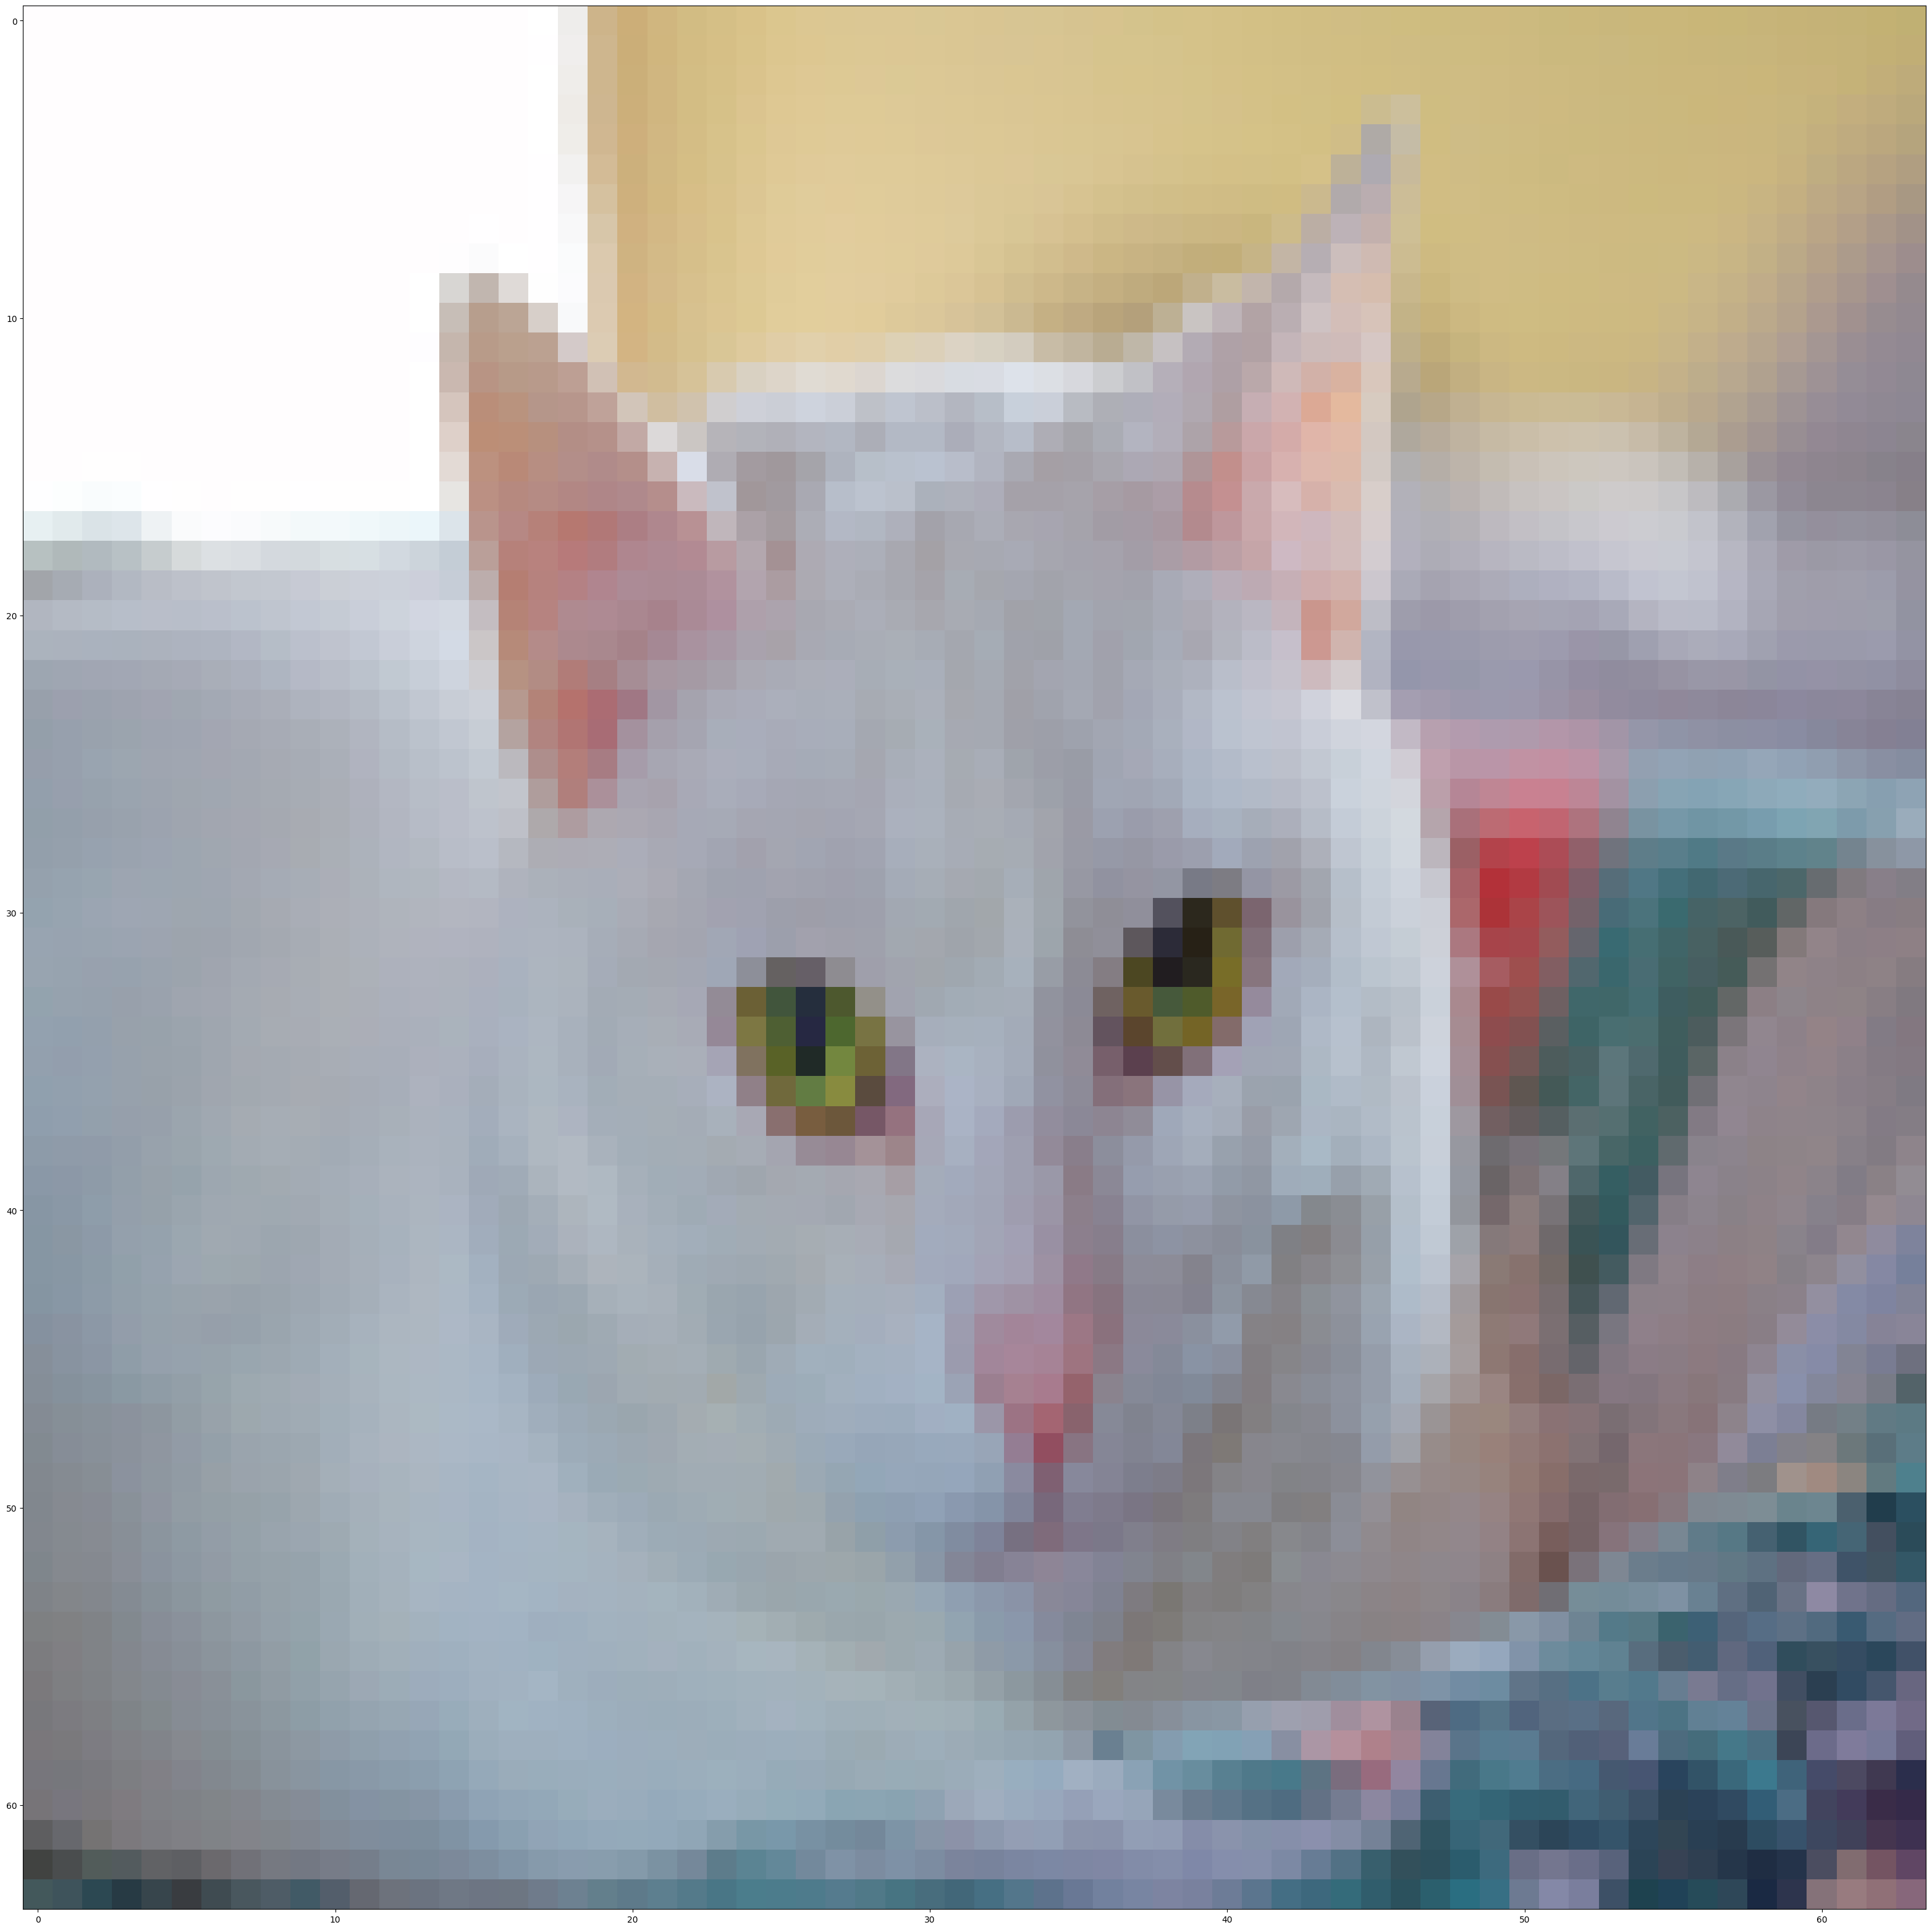

In [29]:
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**Note**

There are serious problems with the L-layer Model as the accuracy is only 34%. My guess is that there is something wrong with my linear_activation_backward() function (or perhaps really bad hyperparameters). Hopefully, I will fix this problem soon. Apologies!